### Content Library Product Cannabilzation & Value Added Case Study
#### An Advanced Analytics (AA) Study by Dan Colarusso

#### Purpose:

##### At my previous role at Gerson Lehrman Group (GLG), the company offered subscriptions with varying usage rules and caps to access our network of 'Experts' across a suite of products: calls, events, custom studies, and eventually professionally curated library content. Library content is bundled with a premium subscription option. Contract pricing is based on a model of rules such as: active users, region, business unit, etc. 

##### While on the Advanced Analytics team (AA), a group of stakeholders approached AA with requests with a few business questions for their long term strategy. They were concerned that an increase in library usage led to decreases in call usage. They referred to this potential event as cannibalization. Further, there were additional questions from the senior leadership team surrounding the average value increaed or decreased to a client contract when the library add-on was subscribed too. In summary, they were concerned about the stability of the future of the library product as they headed into a complete product relaunch.

#### Audience:
##### VP of Library Content
##### VP of Events, Americas
##### SVP, Global Head of Content & Events
##### General Manager, EMEA Region

#### Approach:
##### Leverage a complete data science project pipeline to answer the hypotheses "There is no product cannibalization when a client has a library subscription" and "Does there exist is a measurable lift to all product usage such that we can ask for a higher contract price at the end of a contract cycle?" starting from project intake all the way to recommended insights & BI deliverables.

#### Results:
##### We can accept both hypotheses as true. Through correlations used in linear regressions, library usage has moderate correlation levels with other product usage for clients with a library sub. Then with a trained linear regression model, we can attribute x additional projects done yielding an additional ask of y dollars in a contract.

## Outline
### Creating the Data

##### We use a python script to create a dimensonal table for client information. This table will hold contract type, the business unit, and region for a size n clients of our chosing. We use weighted probabilities that best reflects the real world distribution of client characteristics. From this client table, we then an additional py function to generate a facts table for product usage. As before, the usage patterns attempt to reflect actual usage. We then join on unique client ids to create a full usage table.

### Exploratory Data Analysis
##### With our dummy data ready, we can look at distributions of quantitative variables in histograms. We see pareto distributions prevelant throughout the data from usage patterns to active user bases. This is a very common pattern. Only a small % of users will generate the majority of our business. These tails are long enough to push the mean ~1/2 of the standard deviation ahead of the medians for usage. 

##### We can use crosstabulation in Pandas to examine significance between categorical variables and target variable (all usage). We can use kernel density plots to get an eyeball comparison between the usage probability and clients with & without library subs. Even bar plots to show median usage between library types begins to show a potential picture of statistical significance between these groups. We'll also want to quickly check for potential or underlying seasonality in the usage patterns. A simple visual will suffice in this use case as opposed to a formal time series method such as deploying an ARIMA model.

### Data Transformation & Model Prep
##### If they exist, we'll need to impute nulls and address duplicated entries in the tables. For sake of simplicity, we'll assume no outliers to take in account length of the case study (however, this is NOT best data practices and there are plenty of packages to deal with outliers).

##### We have two data problems too account for before we begin training models. First, a transformer needs to be applied to the quantitative data in order to scale down to something resembling normally distributed data. This will make the data easier to digest for linear or more sophisticated ML models. Second, we'll need to encode categorical to dummy variables. We will construct a ColumnTransformer pipeline to run both processes in one go.

##### We'll also need to check for co-variance and variance inflation. If one of the variables is inflating the behavior of another, we'll need to check by how much so and then drop it prior to training models. We may also drop categorical variables with chi-squared values against the target variable that do not meet the standard p values of statistical significance. 

##### As part of the exhaust of checking for variance inflation and correlations, we can answer the hypothesis of product cannibalization. Running any type of model requires independent variables. By this definition, we are examine cannibalization. If cannibalization exists, we would see negative correlation values. Then, any type of regression or modeling work would have to stop or be adjusted. 

### Modeling Training & Running
##### The right tool for the right job. We'll start off as simple as we can with training on a subset of our data before testing on the omitted data. If need be, we can try out a more sophisticated model or ML model if a linear regression turns up empty handed or yields unreliable results (and NOT results we simply don't like). In each case, we can apply a tool such as a folded GridSearch to tune our hyperparameters to produce a higher quality model.

##### With hyperparameters selected based on its highest accuracy score and confirmed no overfitting exists with test data, we can run a formal test by creating additional client dimension and usage facts. We will assume no library contracts first to see the all usage median, then re-run to compare a median with library enabled. Combined with the integrity of a proper data science model (and assuming it passed code & project review), we can ultimately answer the question on added value. 

### Recommended Action Items & Next Steps

### Creating the Data

In [1]:
#### import all of needed packages in one go. 
import pandas as pd
import numpy as np
from numpy.random import default_rng
from scipy.stats import chi2_contingency
from datetime import datetime, timedelta, date ###basic packages esp. for EDA

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer ### what we need for scaling and transformations

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import linear_model ### packages to tune and build models.

import matplotlib.pyplot as plt
import seaborn as sns ## visualization packages.

In [2]:
###create dummy client data
def make_client_table(size):
    business_unit = ['Professional Services', 'Healthcare', 'Private Equity', 'Industrials', 'Technology']
    region = ['Americas', 'EMEA'] 
    contract_type = ['OSP', 'OSP-Cap', 'C-OSP']
    library_sub = [True, False]
    rng = default_rng()

    df = pd.DataFrame({
        'client_id' : rng.choice(99999, size=size, replace=False),
        'business_unit' : [np.random.choice(business_unit) for i in range(size)],
        'region' : [np.random.choice(region, p=[0.70, 0.30]) for i in range(size)],
        'contract_type' : [np.random.choice(contract_type, p=[0.50, 0.25, 0.25]) for i in range(size)],
        'library_sub' : [np.random.choice(library_sub, p=[0.33, 0.67]) for i in range(size)],
        'active_users' : np.ceil([ (np.random.pareto(2.75)) * 1 for i in range(size)]) + 1
    })   

    return df

size = 6000
d_client = make_client_table(size)

In [3]:
total_months = 24
data = []
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=30*total_months)).strftime('%Y-%m-%d')
months = pd.period_range(start=start_date, end=end_date, freq='M')

for i in list(d_client.client_id):
    for month in months:
        if d_client.loc[d_client['client_id'] == i]['region'].iloc[0] == 'Americas':
            call_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.6, 1) )
            events_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.5, 1) )
            library_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.3, 1) )
            other_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.2, 1) )
            data.append([i, month, call_usage, events_usage, library_usage, other_usage]) 
        elif d_client.loc[d_client['client_id'] == i]['region'].iloc[0] == 'EMEA':
            call_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.55, 1))
            events_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.3, 1) )
            library_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.5, 1) )
            other_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.2, 1) ) 
            data.append([i, month, call_usage, events_usage, library_usage, other_usage]) 

df = pd.DataFrame(data, columns = ['client_id', 'month', 'call_usage', 'events_usage', 'library_usage', 'other_usage'])

In [4]:
for i in df.select_dtypes(include='object'):
    df[i] = df[i].astype('float64')
f_usage = df.merge(d_client, on='client_id', how='left')

In [5]:
### apply multpliers based on real life usage patterns between BUs and regions
def multipliers(df):
    df.loc[(df.library_sub == True) & (df.active_users <= 5), 'call_usage'] = df.loc[(df.library_sub == True) & (df.active_users <= 5), 'call_usage'] * 1.75
    df.loc[(df.library_sub == True) & (df.active_users <= 5), 'events_usage'] = df.loc[(df.library_sub == True) & (df.active_users <= 5), 'events_usage'] * 1.50
    df.loc[(df.library_sub == True) & (df.active_users <= 5), 'other_usage'] = df.loc[(df.library_sub == True) & (df.active_users <= 5), 'other_usage'] * 1.50
    df.loc[(df.library_sub == True) & (df.active_users > 5), 'call_usage'] = df.loc[(df.library_sub == True) & (df.active_users > 5), 'call_usage'] * 1.20
    df.loc[(df.library_sub == True) & (df.active_users > 5), 'events_usage'] = df.loc[(df.library_sub == True) & (df.active_users > 5), 'events_usage'] * 1.10
    df.loc[(df.library_sub == True) & (df.active_users > 5), 'other_usage'] = df.loc[(df.library_sub == True) & (df.active_users > 5), 'other_usage'] * 1.10
    ## Here, we make a series of .loc statements. While we can do it with less code with an interrows function, it is inadvisable to do so.
    ## Iterrows function if quite computationally taxing on the cpu. The machine will run python scripts on each row, interatively. 
    ## Whereas using .loc will splice in the df and run in one go. 

    df.loc[( ((df.business_unit == 'Professional Services') | (df.business_unit == 'Private Equity' ))
          & (df.region == 'EMEA')), 'library_usage'
          ] = df.loc[( ((df.business_unit == 'Professional Services') | (df.business_unit == 'Private Equity' ))
          & (df.region == 'EMEA')), 'library_usage'
          ] * 1.25    

    df.loc[( (df.business_unit == 'Professional Services') & (df.region == 'Americas')), 'library_usage'
           ] = df.loc[( (df.business_unit == 'Professional Services') & (df.region == 'Americas')), 'library_usage'
           ] * 0.50       

    df.loc[( ((df.business_unit == 'Healthcare') | (df.business_unit == 'Private Equity' ))
             & (df.region == 'Americas')), 'library_usage'
           ] = df.loc[( ((df.business_unit == 'Healthcare') | (df.business_unit == 'Private Equity' ))
             & (df.region == 'Americas')), 'library_usage'
           ] * 1.25       

    df.loc[df['library_sub'] == False, 'library_usage'] = df.loc[df['library_sub'] == False, 'library_usage'] * 0.10     

multipliers(f_usage)

### Exploratory Data Analysis

#### Relevant Stakeholder Notes from Intake Meetings

##### According to client surveys and feedback, clients are impressed with the quality of content hosted in the library. Clients view the content as higher quality relative to the competition and is trusted in strategic decision making. One of the biggest areas for improvement is increasing the volume of content available. However, clients state they feel more compelled to do additional work with us. They view the suite of products as tools in a bigger kit rather being siloed into a set number of uses. In other words, if they are impressed with library quality, they would approach us to call an expert for a different project.

##### Finance has a semi working model for OSP Cap and C-OSP type subs due to how easily transactions are tracked within the general ledger. If need be, we can just focus on OSP contracts when trying to model added value. Their model shows modest lifts to overall usage, but there's uncertainity to the validity of the results. Project code in GitHub shows unscored models. Adherence to code & project review isn't perfect.

In [6]:
f_usage.describe()

,client_id,call_usage,events_usage,library_usage,other_usage,active_users
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,49895.211167,4.488243,3.588575,1.162386,2.928583,2.260500
std,28894.290344,4.092820,2.732151,1.736897,1.611809,0.897577
min,18.000000,2.000000,2.000000,0.100000,2.000000,2.000000
25%,24584.750000,2.000000,2.000000,0.200000,2.000000,2.000000
50%,49575.500000,3.500000,3.000000,0.300000,2.000000,2.000000
75%,74916.500000,5.250000,4.000000,2.000000,3.000000,2.000000
max,99990.000000,143.000000,120.000000,55.000000,64.000000,20.000000


In [7]:
f_usage.isnull().sum()

client_id        0
month            0
call_usage       0
events_usage     0
library_usage    0
other_usage      0
business_unit    0
region           0
contract_type    0
library_sub      0
active_users     0
dtype: int64

In [8]:
f_usage.duplicated().sum()

0

In [9]:
f_usage.dtypes

client_id            int64
month            period[M]
call_usage         float64
events_usage       float64
library_usage      float64
other_usage        float64
business_unit       object
region              object
contract_type       object
library_sub           bool
active_users       float64
dtype: object

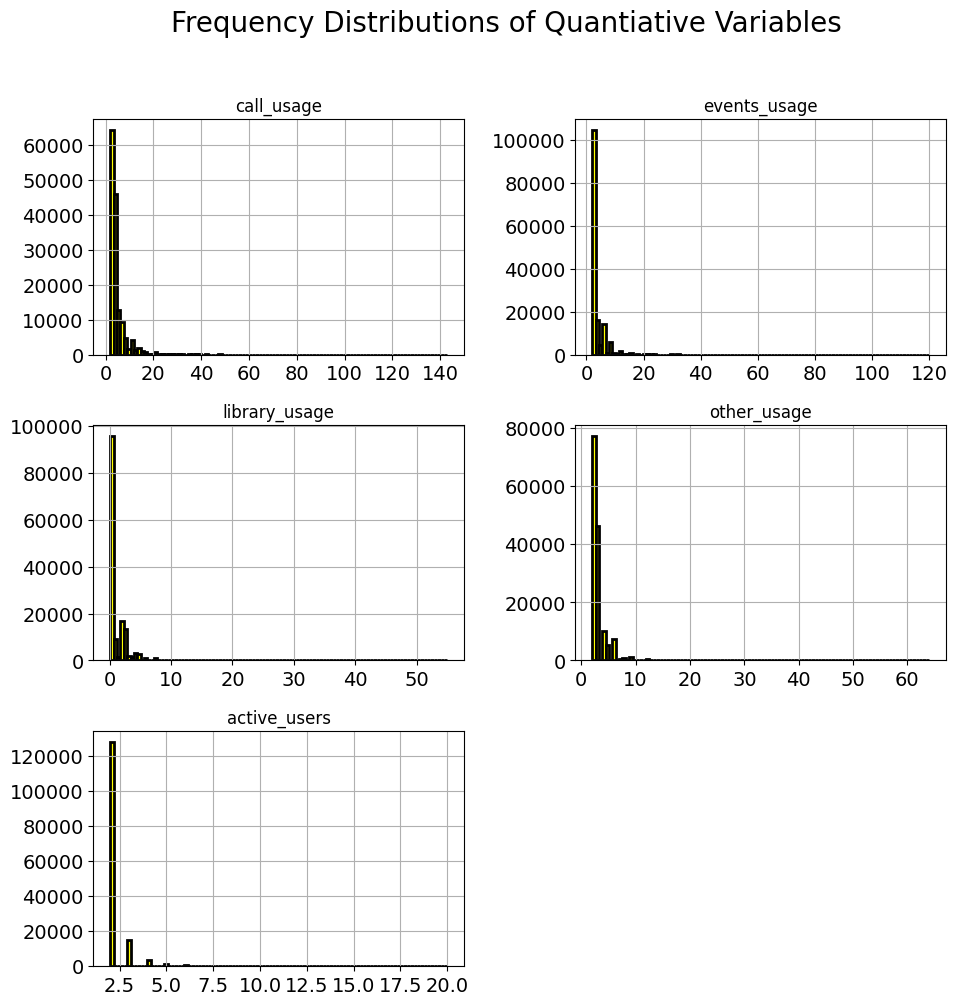

In [10]:
def make_histograms(df):
    histo = df.select_dtypes(include = ['float64'])
    histo.hist(figsize=(11,11), bins = 100, xlabelsize=14, ylabelsize=14
                , color='yellow', linewidth=2, edgecolor='black')

    plt.suptitle('Frequency Distributions of Quantiative Variables', fontsize=20)
    plt.show()

make_histograms(f_usage)

In [11]:
f_usage['all_usage'] = f_usage.call_usage + f_usage.events_usage + f_usage.library_usage + f_usage.other_usage

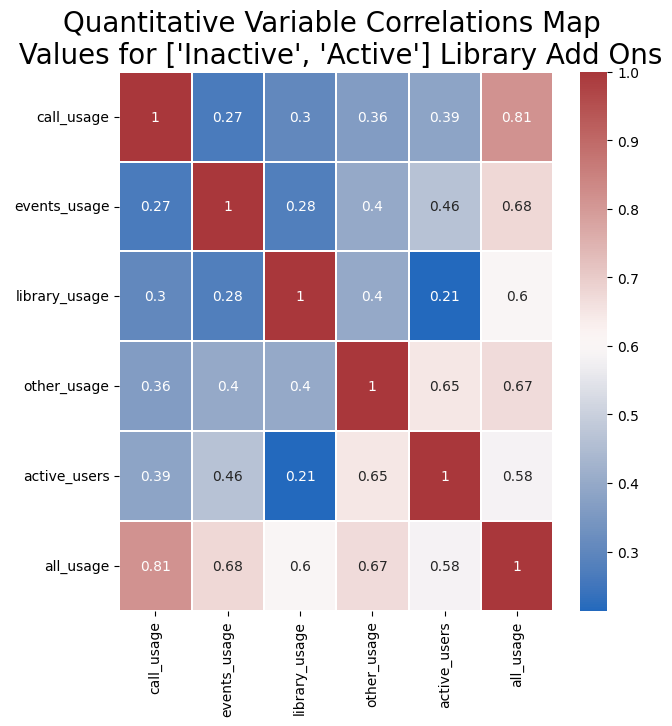

In [12]:
def make_correlations(df):
    corr_fig, ax = plt.subplots(figsize=(7,7))
    df_corr = sns.heatmap(df.select_dtypes(include = ['float64']).corr(), linewidth = 0.25, cmap='vlag', annot=True)
    a = list(pd.Series(df.library_sub.unique()).map({True: 'Active', False : 'Inactive'}))
    plt.title('Quantitative Variable Correlations Map \n Values for ' + str(a) + ' Library Add Ons', fontsize = 20)
    plt.show()

make_correlations(f_usage)

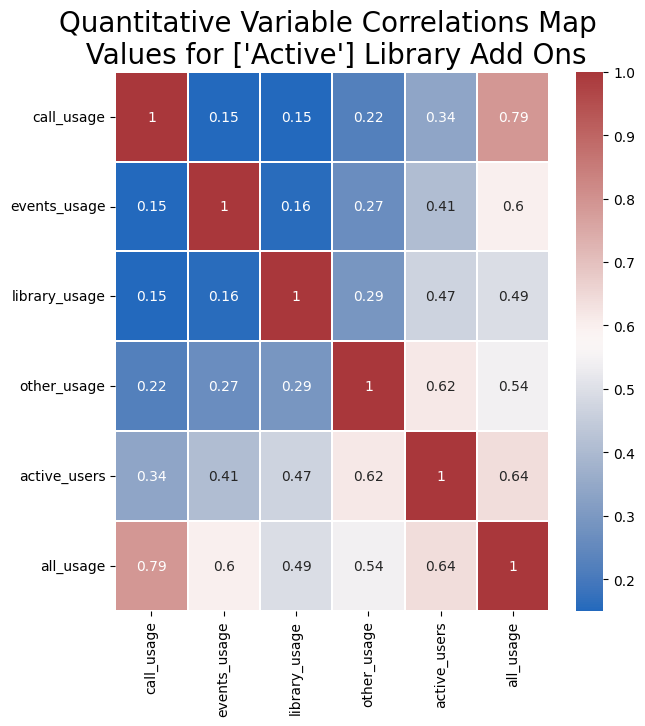

In [13]:
make_correlations(f_usage[f_usage.library_sub == True])

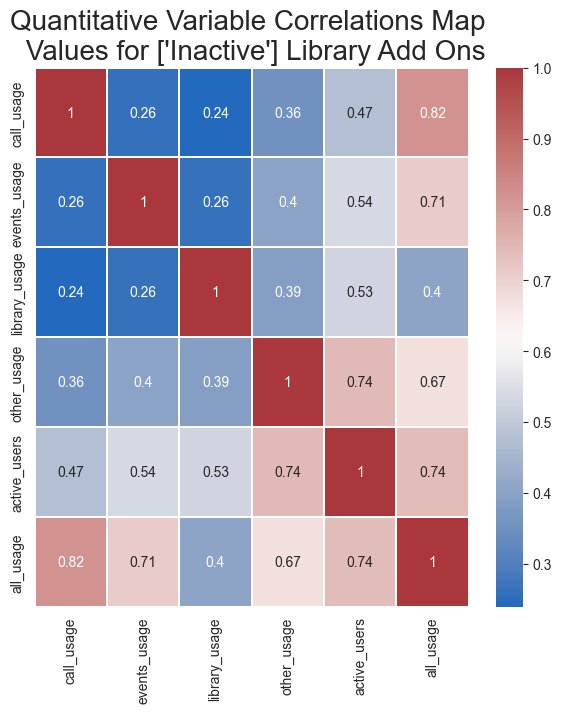

In [129]:
make_correlations(f_usage[f_usage.library_sub == False])

In [14]:
csq_library = chi2_contingency(pd.crosstab(f_usage['all_usage'], f_usage['library_sub']))
print(csq_library[1])

0.0


In [15]:
csq_bu = chi2_contingency(pd.crosstab(f_usage['all_usage'], f_usage['business_unit']))
print(csq_bu[1])

0.0


In [16]:
csq_contract =chi2_contingency(pd.crosstab(f_usage['all_usage'], f_usage['contract_type']))
print(csq_contract[1])

8.86947741975229e-78


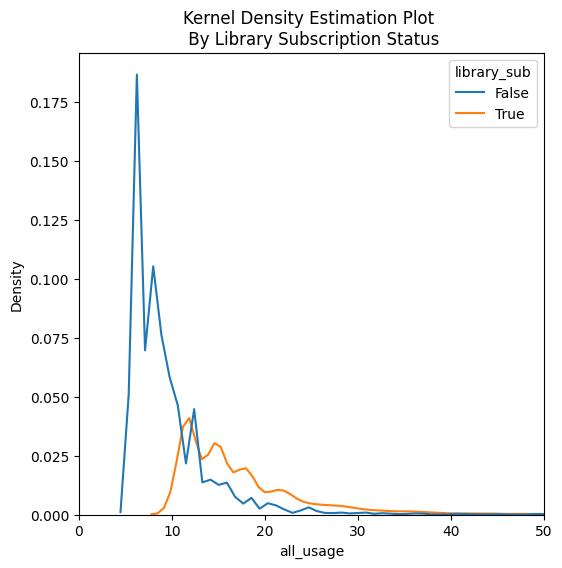

In [17]:
kde_fix, ax = plt.subplots(figsize=(6,6))
sns.kdeplot(data=f_usage, x='all_usage', hue='library_sub')
ax.set_xlim(left=0, right= 50)

plt.title('Kernel Density Estimation Plot \n By Library Subscription Status')
plt.show()

##### Note the difference in the maximas for the curves. Library subs have probabilities of monthly all in usage greater than non. Non library clients are exhausting their probabilities of bigger usage patterns whereas library clients have a long, probability tail.

<Axes: xlabel='business_unit', ylabel='call_usage'>

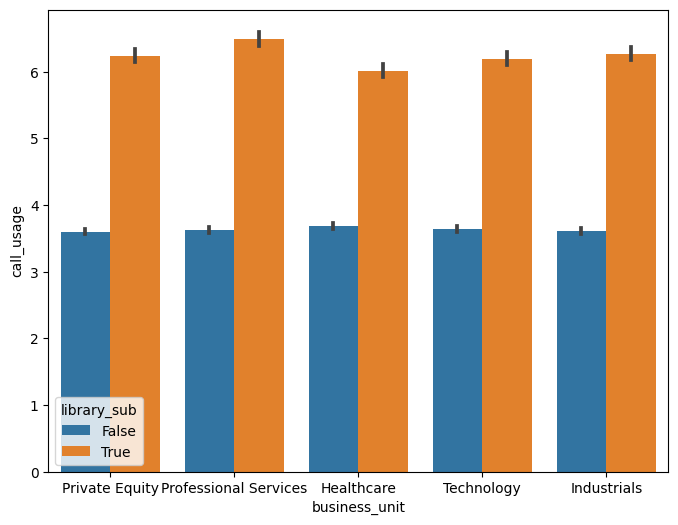

In [18]:
bar_fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data=f_usage, x='business_unit', y='call_usage', hue='library_sub', estimator='mean')

In [19]:
f_usage.groupby(['region', 'library_sub']
               ).agg({'active_users' : 'median',
                      'all_usage' : 'median',
                      'call_usage' : 'median'})

active_users  all_usage  call_usage
region   library_sub                                     
Americas False                 2.0       8.25         2.0
         True                  2.0      15.00         3.5
EMEA     False                 2.0       8.20         2.0
         True                  2.0      15.00         3.5

##### Even at top-level medians across regions and business units while trying to account for active user base sizes, we see a pretty stark difference in all in usage when a client has the option to utilize library. This extends into usage of different products.

In [20]:
agg_df = pd.pivot_table(data=f_usage, values=['call_usage', 'events_usage', 'library_usage', 'other_usage'],
               index = 'month', aggfunc='sum').reset_index()

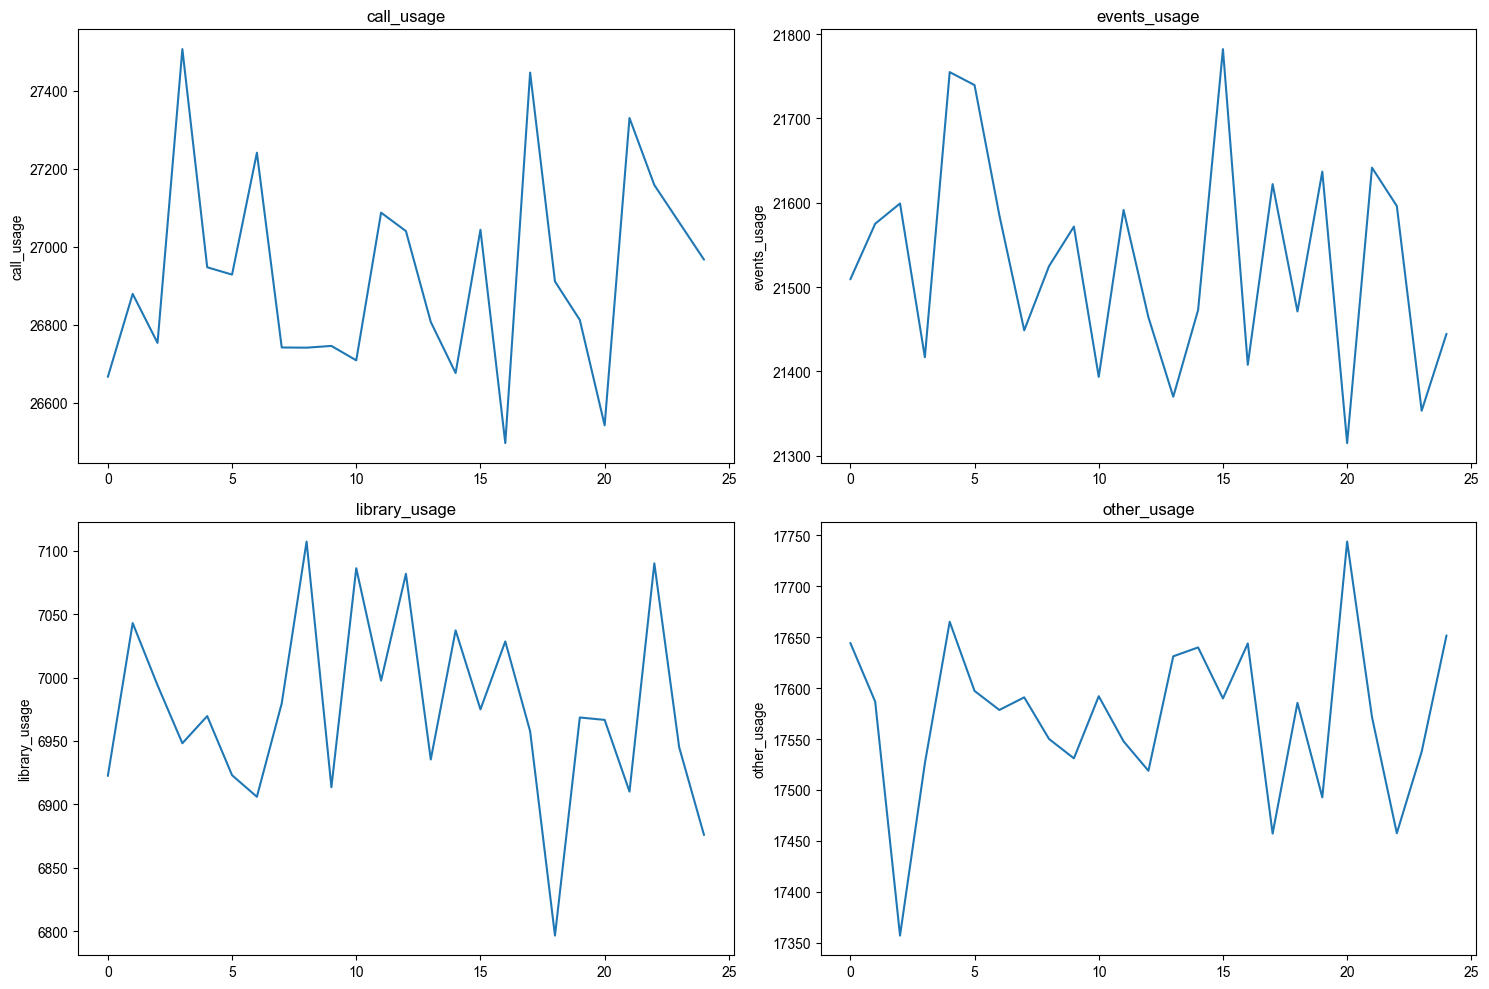

In [21]:
date_fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10)) 
axes = axes.flatten()

###monthcoords = pd.period_range(start=start_date, end=end_date, freq='Q')
sns.set_style("white")

columns = list(agg_df.columns)[1:]
for i, column in enumerate(columns):
    sns.lineplot(data=agg_df, x=agg_df.index, y=column, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

##### Carefully note the axis values for each graph. Not only do we see a pattern of seasonality across the products, we see its variance pretty stable. For this case study, we'll assume no seasonality.

### Data Transformation and Scaling & Model Prep

In [109]:
def calc_vif(df):
    X = df.select_dtypes(include='float64').drop(['all_usage'], axis=1)
    vif_df = pd.DataFrame()
    vif_df['features'] = X.columns
    vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

    return vif_df

calc_vif(f_usage[f_usage.contract_type == 'OSP'])

,features,VIF
0,call_usage,2.775422
1,events_usage,3.636853
2,library_usage,1.845301
3,other_usage,8.389439
4,active_users,9.626400


##### Our target VIF is anything below a 5.0. Active users inflates the variance of the usage types. Let's rerun the VIF once more without active users & see if the others will drop below that mark. We'll also omit library usage as its only moderatly correlated with all usage. In our case, this is acceptable holistically since we're more concerned with the relationship with library subs and the other products. More so, including that usage may cause the model to become overfit

In [110]:
calc_vif(f_usage[f_usage.contract_type == 'OSP'].drop(['library_usage', 'active_users'], axis=1))

,features,VIF
0,call_usage,2.509804
1,events_usage,3.030467
2,other_usage,3.778900


##### This is much better. All quantitative variables are within the acceptable variance inflation limit. We can use these as inputs in a model. For simplicity sake, let's just examine the hypothesis for OSP contracts and keep the model and touch simpler.

In [119]:
X = f_usage[f_usage.contract_type == 'OSP'].drop(['all_usage', 'client_id', 'active_users', 'month', 'contract_type', 'library_usage'], axis=1)
X['library_sub'] = X.library_sub.map(lambda x: 0 if x == False else 1)
y = f_usage[f_usage.contract_type == 'OSP'][['all_usage']]

In [120]:
quants = list(X.select_dtypes(include='float64').columns)
quals = list(X.select_dtypes(exclude=['float64', 'int64']).columns)
### get a list of columns by data type to help build a fully transformed data set w/ proper column names

In [121]:
transformer =  ColumnTransformer(
    [ ('scaler', RobustScaler(), quants),
      ('enc', OneHotEncoder(), quals),
    ],
   remainder='passthrough' 
)    ###build our transformer. Scale the quant. columns and get 0-1 dummy variables for quals.

In [122]:
X_transformed = transformer.fit_transform(X)

In [123]:
X_transformed = pd.DataFrame(X_transformed, columns = list(quants +  transformer.named_transformers_['enc'].get_feature_names_out().tolist() + ['library_sub']))

In [115]:
X_transformed.columns

Index(['call_usage', 'events_usage', 'other_usage', 'business_unit_Healthcare',
       'business_unit_Industrials', 'business_unit_Private Equity',
       'business_unit_Professional Services', 'business_unit_Technology',
       'region_Americas', 'region_EMEA', 'library_sub'],
      dtype='object')

In [124]:
X_transformed.drop(['region_EMEA'], axis=1, inplace=True) ##drop the region to avoid the n+1 dummy trap.

In [125]:
y_scaler = RobustScaler() 
y_scaled = y_scaler.fit_transform(y)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_scaled, test_size = 0.25)

### Model Training & Running

In [45]:
import statsmodels.api as sm

In [ ]:
##Xt_sm = sm.add_constant(X_train)
##model = sm.OLS(y.values.reshape(-1, 1), Xt_sm).fit()

In [127]:
Xt_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, Xt_sm).fit()

In [128]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 2.407e+05
Date:                Mon, 03 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:54:00   Log-Likelihood:                 30105.
No. Observations:               55687   AIC:                        -6.019e+04
Df Residuals:                   55676   BIC:                        -6.009e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [89]:
lr = linear_model.LinearRegression()

In [130]:
X2 = f_usage[f_usage.contract_type == 'OSP'].drop(['all_usage', 'client_id', 'active_users',
                                                  'month', 'contract_type', 'library_usage',
                                                  'business_unit'], axis=1)
X2['library_sub'] = X2.library_sub.map(lambda x: 0 if x == False else 1)
y2 = f_usage[f_usage.contract_type == 'OSP'][['all_usage']]

In [133]:
quants2 = list(X2.select_dtypes(include='float64').columns)
quals2 = list(X2.select_dtypes(exclude=['float64', 'int64']).columns)

transformer2 =  ColumnTransformer(
    [ ('scaler', RobustScaler(), quants2),
      ('enc', OneHotEncoder(), quals2),
    ],
   remainder='passthrough' 
) 

In [135]:
X2_transformed = transformer2.fit_transform(X2)
X2_transformed = pd.DataFrame(X2_transformed, columns = list(quants2 +  transformer2.named_transformers_['enc'].get_feature_names_out().tolist() + ['library_sub']))

In [137]:
X2_transformed.drop(['region_EMEA'], axis=1, inplace=True) 

In [138]:
y2_scaler = RobustScaler() 
y2_scaled = y2_scaler.fit_transform(y)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X2_transformed, y2_scaled, test_size = 0.25)

In [140]:
Xt_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, Xt_sm).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 4.509e+05
Date:                Mon, 03 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:18:08   Log-Likelihood:                 28553.
No. Observations:               55687   AIC:                        -5.709e+04
Df Residuals:                   55681   BIC:                        -5.704e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1606      0.001   -1

In [141]:
lr.fit(X_train, y_train)

LinearRegression()

In [142]:
lr.score(X_test, y_test)

0.9772497106278174

In [144]:
pred_no_library = lr.predict(X_test[X_test.library_sub == 0])
pred_has_library = lr.predict(X_test[X_test.library_sub == 1])

In [149]:
pred_no_library = y2_scaler.inverse_transform(pred_no_library)

In [150]:
pred_has_library = y2_scaler.inverse_transform(pred_has_library)

In [163]:
np.round(pred_no_library.mean())

10.0

In [164]:
np.round(pred_has_library.mean())

18.0

In [92]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

In [93]:
transformer_rf =  ColumnTransformer(
    [ ('scaler', RobustScaler(), quants),
      ('enc', OrdinalEncoder(), quals),
    ],
   remainder='passthrough' 
)    

In [94]:
X_transformed = transformer_rf.fit_transform(X)
X_transformed = pd.DataFrame(X_transformed, columns = list(quants +  transformer_rf.named_transformers_['enc'].get_feature_names_out().tolist() + ['library_sub']))

In [103]:
rfr2 = RandomForestRegressor(criterion = 'squared_error', max_features = 4, n_estimators = 400)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_scaled, test_size = 0.25)

In [106]:
##rfr2.fit(X_train, y_train.values.ravel())
rfr2.fit(X_train, pd.Series(y_train.reshape(-1)).values.ravel() )

RandomForestRegressor(max_features=4, n_estimators=400)

In [107]:
rfr2.feature_importances_

array([0.55808749, 0.27987009, 0.14927595, 0.00390249, 0.00196015,
       0.00690382])

In [ ]:
pred = rfr2.predict(X_test)

In [108]:
feature_scores = pd.Series(rfr2.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

call_usage       0.558087
events_usage     0.279870
other_usage      0.149276
library_sub      0.006904
business_unit    0.003902
region           0.001960
dtype: float64